# 1.4.2.5 Challenge: Boston Marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on [runners and their performance for the Boston Marathon](https://github.com/llimllib/bostonmarathon). Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpcol
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
import scipy
%matplotlib inline

# 1) Data Overview

Let's take a look at a preview of our data to see what we are dealing with.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


# 2) Data Cleaning

Let's clean up the data by converting some data types and restructuring some columns. This will help us run our models and create some nice visualizations.<br><br>

First let's start by creating a heatmap to see which columns are missing significant data.

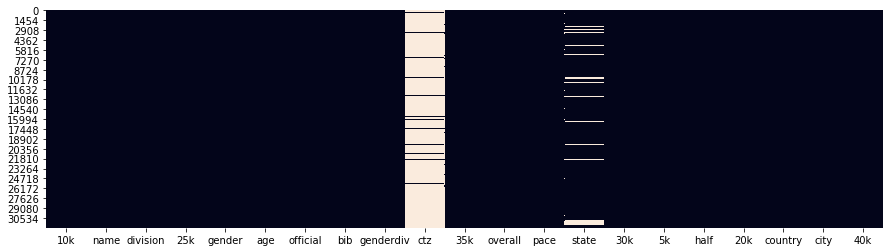

In [6]:
# Plot if any columns have missing data
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(), cbar = False)
plt.show()

Based on this, it seems we can delete the CTZ column as nearly every single row is missing data in that column. As for the STATE column, it makes sense that runners from countries outside the US would have empty values in the STATE column so we will let that slide here.

In [7]:
# Drop the CTZ column as most of the values in that column are NaN.
df.drop(['ctz'], 1, inplace=True)

Let's continue by making sure all checkpoint data is in a numerical type. The checkpoint data is currently split into eight seperate columns and spread out all over the dataset.

In [8]:
# Create a variable for all checkpoint data and convert them to FLOAT dtypes. 
# The 'OFFICIAL' column is already an INT so we will add it in later.
checkpoints = ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']
for i in checkpoints:
    df[i] = df[i].str.replace('-','0.0').astype(float)
    df[i] = df[i].astype(float)

# Add the 'OFFICIAL' column into the CHECKPOINTS variable
checkpoints.append('official')

In [9]:
df[checkpoints].head()

,5k,10k,20k,half,25k,30k,35k,40k,official
0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95
2,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58
4,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23


Next let's convert the values in the AGE column into age brackets. This will allow us to minimize the unique values in the column and will provide better visualization capabilities. To do so, let's use the age brackets created by the Boston Athletic Association as seen [here](https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times).

In [10]:
# Create a dictionary of the age brackets and the ages assigned to them
age_brackets = {'18-34':(18,34),
                '35-39':(35,39),
                '40-44':(40,44),
                '45-49':(45,49),
                '50-54':(50,54),
                '55-59':(55,59),
                '60-64':(60,64),
                '65-69':(65,69),
                '70-74':(70,74),
                '75-79':(75,79),
                '80+':(80,84)}

# Create a function that will assign each age value into an age bracket
def age_to_bracket(x):    
    for bracket in age_brackets: 
        if age_brackets[bracket][0] <= x <= age_brackets[bracket][1]:
            return bracket               
    else: 
        print('Age value -{}- could not be assigned into a bucket'.format(x))
        return np.nan

# Create a new column using the values created by applying the age bracket function
df['Age Bracket'] = df['age'].apply(lambda x: age_to_bracket(x))

In [11]:
df['Age Bracket'].head()

0    45-49
1    18-34
2    40-44
3    18-34
4    40-44
Name: Age Bracket, dtype: object

Now let's convert the values in the BIB column into wave brackets. This will also allow us to minimize the unique values in the column and will provide better visualization capabilities. To do so, let's use the wave brackets created by the Boston Athletic Association as seen [here](http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm).

In [12]:
wave_brackets = {'Elite':(0,100), 
                 'Wave1':(101,8999), 
                 'Wave2':(9000,17999), 
                 'Wave3':(18000,26999), 
                 'Wave4':(27000,50000)}

# Create a function that will assign each bib value into a wave bracket
def bib_to_wave(x):   
    try:
        for wave in wave_brackets:
            if wave_brackets[wave][0] <= float(x) <= wave_brackets[wave][1]: return wave
    except ValueError:
        if 'W' or 'F' in str(x): return 'Elite'
    else: 
        print(float(x))
        return np.nan

# Create a new column using the values created by applying the wave bracket function
df['Wave'] = df['bib'].apply(lambda x: bib_to_wave(x))

In [13]:
df['Wave'].head()

0    Elite
1    Elite
2    Elite
3    Elite
4    Elite
Name: Wave, dtype: object

Here we will convert the values in the COUNTRY column. According to the Boston Athletic Association, only five countries had over 200 participants in the 2014 Boston Marathon - __USA, Canada, United Kingdom, Italy, and Mexico__. Therefore, let's convert all other COUNTRY values to now say "OTHER". This will also allow us to minimize the unique values in the column and will provide better visualization capabilities.<br><br>

After that we will convert the __Gender__ column into binary 1 / 0 for use in our clustering models. 

In [14]:
# Make a variable of the country tags we will be using
countries = ['USA', 'CAN', 'GBR', 'ITA', 'MEX']

# Assign all other countries with the value "OTHER"
df['Country'] = df['country'].apply(lambda x: np.where(x not in countries, 'OTHER', x))

In [15]:
df['Country'].head()

0    OTHER
1    OTHER
2    OTHER
3    OTHER
4    OTHER
Name: Country, dtype: object

In [16]:
# Binarize the gender variable for use in our cluster modeling
df['female'] = df['gender'].apply(lambda x: np.where(x == 'F', 1, 0))
df['female'].head()

0    0
1    1
2    0
3    1
4    0
Name: female, dtype: int64

# 3) Data Analysis

It looks like our data is now relatively clean. Let's make some visualization to have a better understanding of the dataset we are dealing with.<br><br>

First let's see how the participant counts compare by __gender__.

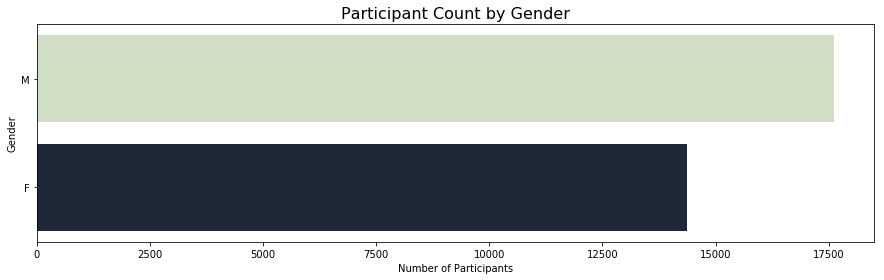

In [17]:
# Create a countplot for Male and Female participants
plt.figure(figsize=(15,4))
sns.countplot(y=df['gender'], palette = sns.cubehelix_palette(2, rot = -0.5))
plt.title('Participant Count by Gender', fontsize=16)
plt.xlabel('Number of Participants')
plt.ylabel('Gender')
plt.show()

Next let's see the __age count by gender__.

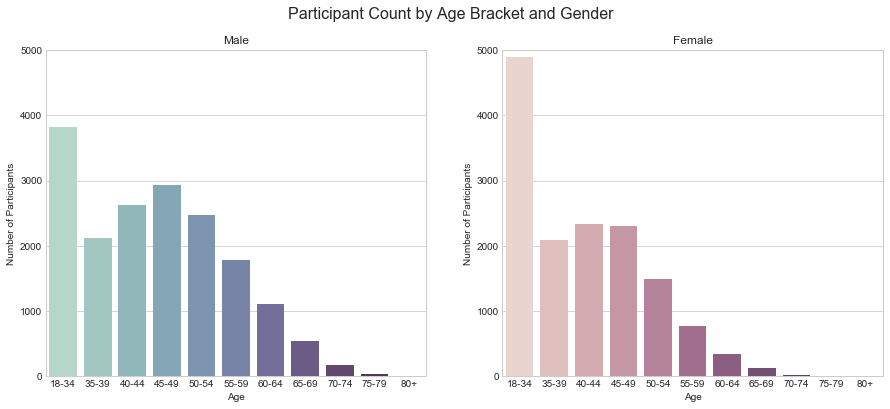

In [18]:
# Create a countplot for participant ages by gender
plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Participant Count by Age Bracket and Gender', fontsize=16)

male   = df[df['gender'] == 'M']['Age Bracket']
female = df[df['gender'] == 'F']['Age Bracket']
frames = [male, female]
labels = ['Male', 'Female']

palettes = {}
palettes['Male']   = sns.cubehelix_palette(len(age_brackets), start=1, rot=-0.75, 
                                           light=0.8, dark=0.2)
palettes['Female'] = sns.cubehelix_palette(len(age_brackets))

for idx, ax in enumerate([ax0, ax1]):
    sns.countplot(frames[idx], ax = ax, 
                  order = age_brackets,
                  palette = palettes[labels[idx]],
                  label = labels[idx])
    ax.set(ylim = (0, 5000), ylabel = 'Number of Participants', xlabel = 'Age')
    ax.set_title(labels[idx])

Here let's make a barplot of the participants' nationalities.

In [19]:
# Create a value-count table to see the counts of runners from each country
country_sort = df['Country'].value_counts(ascending=True)
country_sort = country_sort.to_frame()

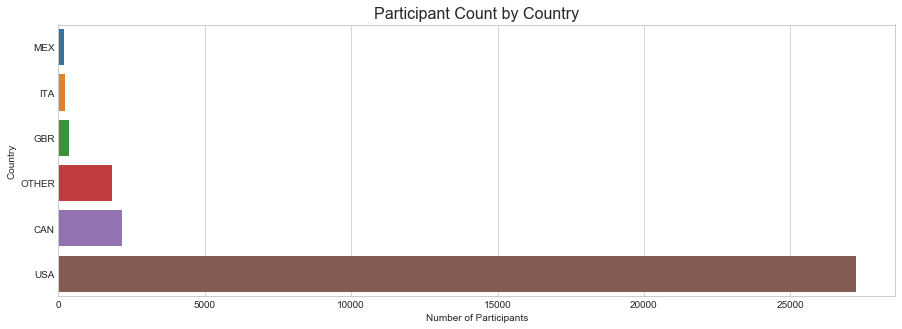

In [20]:
# Create a countplot for Male and Female participants
plt.figure(figsize=(15,5))
sns.barplot(x = 'Country', y = country_sort.index, data = country_sort)
plt.title('Participant Count by Country', fontsize=16)
plt.xlabel('Number of Participants')
plt.ylabel('Country')
plt.show()

Now let's see how many runners participated in each wave.

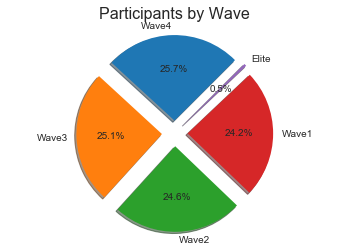

In [21]:
# Create a dataframe of the wave information
wave_df = df['Wave'].value_counts().to_frame()

# Create a pie chart for waves
plt.pie(wave_df['Wave'], explode = (0.15, 0.15, 0.15, 0.15, 0.15), labels = wave_df.index,
autopct = '%1.1f%%', shadow = True, startangle = 45)
plt.title('Participants by Wave', fontsize=16) 
plt.axis('equal')
plt.show()

Here let's see how each gender faired at each checkpoint.

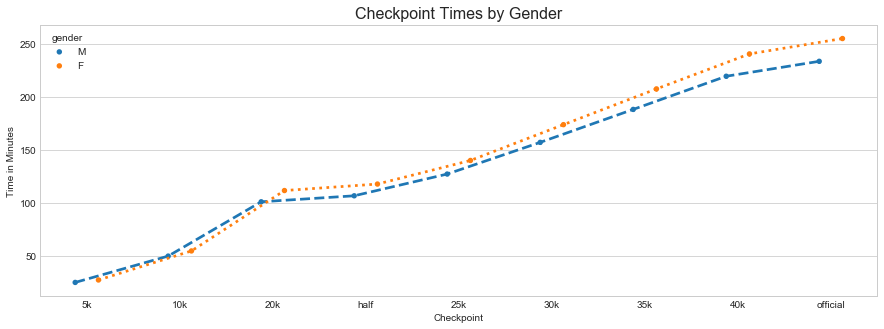

In [22]:
# Create a new dataframe that melts the checkpoint data by gender
stacked_checkpoints = pd.melt(df, value_vars = checkpoints, var_name='checkpoint',
                              value_name='time', id_vars=['gender'])

plt.figure(figsize=(15,5))
sns.pointplot(data=stacked_checkpoints, x='checkpoint', y='time', hue='gender',
                   markers=['.','.'], linestyles=['--', ':'], ci=95, orient="v", 
                   dodge=0.25)

plt.title('Checkpoint Times by Gender', fontsize=16)
plt.ylabel('Time in Minutes')
plt.xlabel('Checkpoint')
plt.show()

# 4) Modeling

In [23]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import pairwise_distances

First let's create a dataframe of all the features we will be using.

In [24]:
df.head(2)

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,...,5k,half,20k,country,city,40k,Age Bracket,Wave,Country,female
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,...,8.02,39.72,37.65,JPN,Fukuoka,80.43,45-49,Elite,OTHER,0
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,...,16.22,69.47,65.83,KEN,Eldoret,132.10,18-34,Elite,OTHER,1


In [25]:
# Create a blank dataframe called 'modeling_df'
modeling_df = pd.DataFrame()

# Add the columns that are already in the correct format
modeling_df['age'] = df['age']
modeling_df['female'] = df['female']
modeling_df['division'] = df['division']
modeling_df['genderdiv'] = df['genderdiv']
modeling_df['overall'] = df['overall']

# Add checkpoint values as seperate columns
for checkpoint in checkpoints:
    modeling_df[checkpoint] = df[checkpoint]

# Add waves as seperate columns
for wave in df['Wave'].unique():
    modeling_df[wave] = np.where(df['Wave'] == wave, 1, 0)

# Add countries with significant levels of participation as binary columns
# First add the 'OTHER' country value into the variable called 'countries'
countries.append('OTHER')
for country in countries:
    modeling_df[country] = np.where(df['Country'] == country, 1, 0)

modeling_df.head()

,age,female,division,genderdiv,overall,5k,10k,20k,half,25k,...,Wave1,Wave2,Wave3,Wave4,USA,CAN,GBR,ITA,MEX,OTHER
0,47,0,8,8,8,8.02,17.37,37.65,39.72,47.67,...,0,0,0,0,0,0,0,0,0,1
1,33,1,1,1,21,16.22,32.58,65.83,69.47,82.43,...,0,0,0,0,0,0,0,0,0,1
2,41,0,1,1,1,7.75,16.62,36.10,38.03,45.80,...,0,0,0,0,0,0,0,0,0,1
3,24,1,3,3,27,16.20,32.57,65.83,69.47,82.43,...,0,0,0,0,0,0,0,0,0,1
4,40,0,2,2,2,8.02,17.12,36.58,38.60,46.37,...,0,0,0,0,0,0,0,0,0,1


Many of our features span different scales so let's normalize the data so we can compare the features against each other.

In [26]:
# Normalize the data
X = modeling_df
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_normed = pd.DataFrame(np_scaled, columns=list(modeling_df))
X_normed.head()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,female,division,genderdiv,overall,5k,10k,20k,half,25k,...,Wave1,Wave2,Wave3,Wave4,USA,CAN,GBR,ITA,MEX,OTHER
0,0.460317,0.0,0.001003,0.000398,0.000219,0.092237,0.154565,0.167818,0.167829,0.164937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.238095,1.0,0.000000,0.000000,0.000626,0.186544,0.289909,0.293425,0.293531,0.285205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.365079,0.0,0.000000,0.000000,0.000000,0.089132,0.147891,0.160909,0.160688,0.158467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.095238,1.0,0.000287,0.000114,0.000814,0.186314,0.289820,0.293425,0.293531,0.285205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.349206,0.0,0.000143,0.000057,0.000031,0.092237,0.152340,0.163049,0.163096,0.160439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Conduct a Principal Component Analysis so we can plot the data on a two dimensional graph.

In [27]:
# Coduct PCA on the normalized dataframe
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_normed)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]
X_pca

array([[ 0.9533354 , -0.00471281],
       [ 0.47069423, -0.52844741],
       [ 0.96312294, -0.00454796],
       ...,
       [-0.91949159,  0.37123462],
       [-1.02522832,  0.40987653],
       [-0.23819122,  0.76537496]])

# 5) Clustering
## Mean Shift Clustering

In [28]:
# Mean Shift Clustering
bandwidth = estimate_bandwidth(X_normed, quantile = 0.21, n_samples = 500, n_jobs = 1)

# Fit the model
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms.fit(X_normed)

# Extract cluster assignments for each datapoint
labels = ms.labels_

# Coordinates of the cluser centers
cluster_centers = ms.cluster_centers_

# Count our clusters
n_clusters_ = len(np.unique(labels))
print('Number of estimated clusters: {}'.format(n_clusters_))

ms_labels = ms.predict(X_normed)

ms

Number of estimated clusters: 4


MeanShift(bandwidth=1.4330546247202518, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=None, seeds=None)

Let's see what the clusters look like.

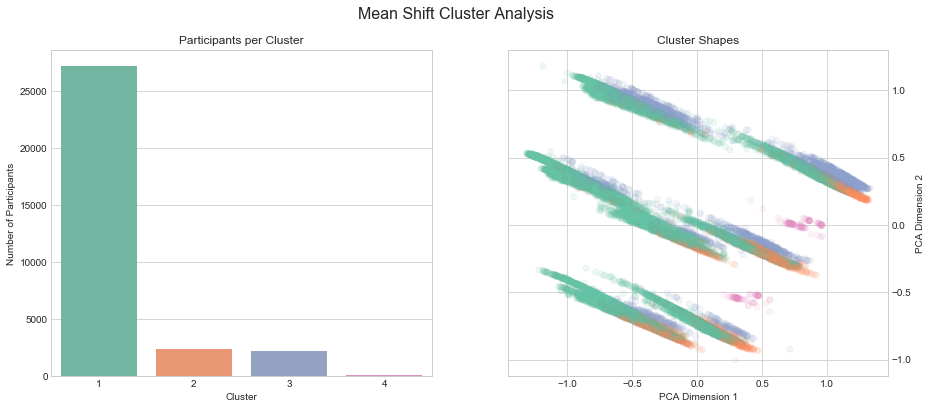

In [29]:
# Add the clusters to the dataframes
modeling_df['cluster'] = ms_labels + 1
df['cluster'] = ms_labels + 1

# Generate color palettes for the plots
palettes['clust_rgb'] = sns.color_palette('Set2', n_clusters_).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')

plt.figure(figsize=(15,6))

# Create a countplot of the clusters
ax1 = plt.subplot(1, 2, 1)    
sns.countplot(x = modeling_df['cluster'], palette=sns.color_palette(palettes['clust_rgb']))

plt.title('Participants per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Participants')

# Visualize the clusters
ax2 = plt.subplot(1, 2, 2)    
plt.scatter(x = pca_1, y = pca_2, c= modeling_df['cluster'], 
            cmap = palettes['clust_cmap'], alpha=0.1)
plt.title('Cluster Shapes')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.suptitle('Mean Shift Cluster Analysis', fontsize=16)
plt.show()

Being that we cannot verify the cluster accuracy against any originally-dictated values, we are forced to use a less accurate measuring technique. Here we will use the Silhouette Coefficient method. This method rates each point's distance from points in neighboring clusters on a scale of -1 to +1. We will take four equally-sized samples and find the average of the Silhouette Coefficients for all point in the sample. If the values are consistent, we can determine that the clusters are accurate. 

In [30]:
# Split the data in half
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_normed,
    X_pca,
    test_size=0.5,
    random_state=42)

# We want to create four samples so lets split the two we just created in half as well
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

counter = 0
print('SILHOUETTE COEFFICIENTS')
print('-----------------------')
for sample in [X1, X2, X3, X4]:
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
    labels = model.labels_
    counter += 1
    print('Sample {}: {}'.format(counter, round(metrics.silhouette_score(sample, labels, metric='euclidean'),4)))

SILHOUETTE COEFFICIENTS
-----------------------
Sample 1: 0.2165
Sample 2: 0.2387
Sample 3: 0.1891
Sample 4: 0.1969


All of the coefficients are positive values and somewhat consistent which indicates that the clustering has a possibility of being accurate!

# 6) Outcome Summary
## 6A - Cluster Demographics
Let's take a look at how the clusters compare demographically.

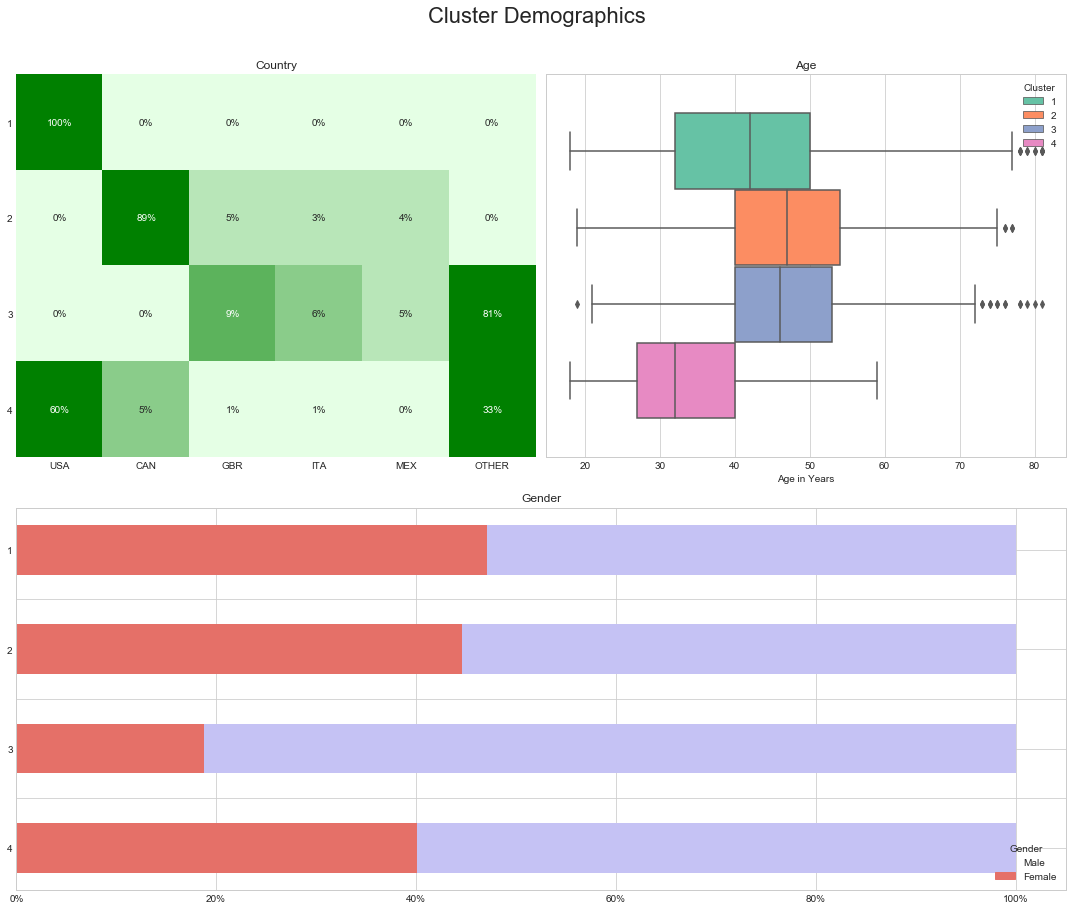

In [39]:
# Plot a figure summarizing demographics by cluster
fig = plt.figure(figsize=(15,12))
gs = GridSpec(1, 4)
cluster_labels = ['{}'.format(x) for x in range(1, n_clusters_ + 1)]
gender_labels = ['', '1', '', '2', '', '3', '', '4']

# Country
ctry_data = {}
for cluster in np.arange(1, n_clusters_ + 1):
    ctry_data[cluster] = [(df[(df['cluster'] == cluster) & (df['Country'] == country)]['Country'].count())
                          /df[df['cluster'] == cluster].shape[0] for country in countries]
# Plot the data
ax1 = plt.subplot(2, 2, 1)
sns.heatmap(pd.DataFrame(ctry_data, index = countries).transpose(), annot=True, fmt=".0%",
            cmap = sns.light_palette("green"), cbar = False, vmin = 0, vmax = 0.15)
ax1.set_yticklabels(cluster_labels)
plt.yticks(rotation=0) 
plt.title('Country')

# Age
# Create a placeholder column
modeling_df['y'] = 1
ax2 = plt.subplot(2, 2, 2)    
sns.boxplot(y = 'y', x = 'age', data = modeling_df, hue = 'cluster',
            palette = sns.color_palette(palettes['clust_rgb']), orient = 'h',
            saturation = 1)
ax2.axes.get_yaxis().set_visible(False)
plt.title('Age')
plt.xlabel('Age in Years')
plt.legend(loc = "upper right", title = 'Cluster')

# Gender
ax3 = plt.subplot(2, 1, 2)
for cluster in np.arange(n_clusters_ + 1):
    pct_female = modeling_df[modeling_df['cluster'] == cluster]['female'].mean()
    std_female = modeling_df[modeling_df['cluster'] == cluster]['female'].std()
    pct_male   = 1 - pct_female
    std_male   = 1 - std_female
    
    pfemale = plt.barh(cluster, pct_female, 0.5, color = '#e57068')
    pmale   = plt.barh(cluster, pct_male, 0.5, left = pct_female, color = '#c5c2f4')

plt.gca().invert_yaxis()
ax3.set_yticklabels(gender_labels)
ax3.set_xticklabels(['{}%'.format(tick) for tick in np.arange(0,120,20)])
gender_legend = [mpatches.Patch(color = '#c5c2f4', label = 'Male'),
                 mpatches.Patch(color = '#e57068', label = 'Female')]
plt.legend(handles = gender_legend, loc = "lower right", title='Gender')
plt.title('Gender')

# Define overall aesthetics and plot.
plt.suptitle('Cluster Demographics', fontsize=22, y=1.05)
plt.tight_layout()
plt.show()

## 6B - Cluster Performance
Let's take a look at how the clusters' performance in the marathon compare with each other.

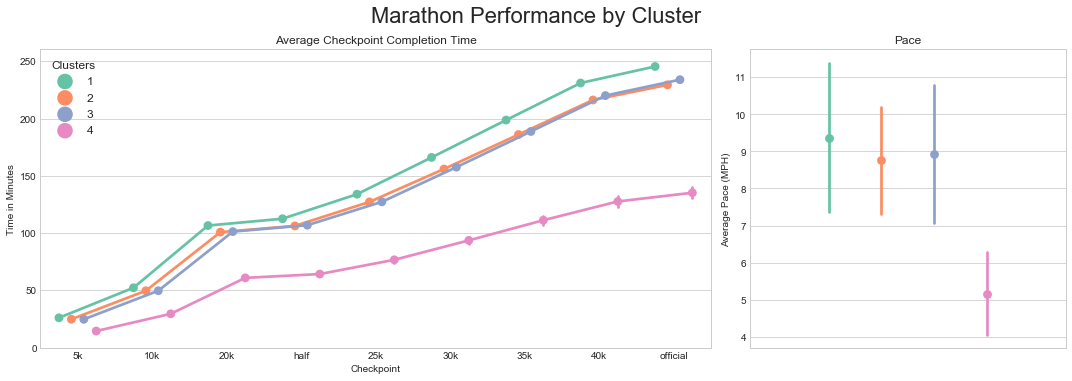

In [47]:
# Plot a marathon performance cluster comparison graph
gs = GridSpec(1, 3)
plt.figure(figsize=(15,5))

# Stack the checkpoint data into a single dataframe
stacked_checkpoints = pd.melt(df, value_vars = checkpoints, var_name = 'checkpoint',
                              value_name = 'time', id_vars = ['cluster'])

## CHECKPOINT PLOT
# Plot the average checkpoint times for each wave using the new stacked data
ax1 = plt.subplot(gs[0, 0:2])    
sns.pointplot(data = stacked_checkpoints, x = 'checkpoint', y = 'time', hue = 'cluster',
              palette = sns.color_palette(palettes['clust_rgb']), ci = 95, orient = "v",
              dodge = 0.5)
plt.title('Average Checkpoint Completion Time')
plt.ylabel('Time in Minutes')
plt.xlabel('Checkpoint')

lg = ax1.legend(title = 'Clusters', markerscale = 2, fontsize = 12)
title = lg.get_title()
title.set_fontsize(12)

## PACE PLOT
# Create a placeholder column
df['y'] = modeling_df['y']
ax2 = plt.subplot(gs[0, 2])
sns.pointplot(x = 'y', y = 'pace', hue = 'cluster', data = df, ci = 'sd',
              palette = sns.color_palette(palettes['clust_rgb']), dodge = 0.5)
ax2.legend_.remove()
ax2.set_xticklabels('')
ax2.axes.get_xaxis().set_visible(False)

plt.ylabel('Average Pace (MPH)')
plt.title('Pace')

# OVERALL PLOTS INFORMATION
plt.suptitle('Marathon Performance by Cluster',fontsize=22, y=1.05)
plt.tight_layout()
plt.show()

## 6C - Cluster Profiles
Let's take a deeper look into the average feature values for each cluster as well as how many participants in each cluster were in each wave and from which country. Let's see what we learn.

In [85]:
# Create a pivot table based on cluster averages
cluster_df = df.groupby(['cluster']).mean()
cluster_df = cluster_df[['age', 'female', 'overall', 'division', 'genderdiv', 'half',
                         'official', 'pace']]
cluster_df['mph'] = round(60 / cluster_df['pace'], 2)
cluster_df

,age,female,overall,division,genderdiv,half,official,pace,mph
cluster,,,,,,,,,
1,41.701477,0.470787,16347.836481,2049.658521,8168.299956,112.497315,245.514618,9.371566,6.40
2,47.216427,0.445585,13850.121971,1151.539630,7060.289528,106.242600,229.468932,8.760152,6.85
3,46.423218,0.187843,14238.549817,1471.921846,8228.373400,106.856965,233.985498,8.932655,6.72
4,33.591837,0.401361,290.891156,48.469388,115.741497,64.176463,135.198435,5.164762,11.62


In [72]:
# Create a pivot table based on participants in each wave and cluster
cluster_wave = df.pivot_table(values = 'name', columns = 'Wave', index = 'cluster',
                              aggfunc = 'count', margins = True)
cluster_wave

Wave,Elite,Wave1,Wave2,Wave3,Wave4,All
cluster,,,,,,
1,NaN,6346.0,6586.0,6877.0,7405.0,27214
2,NaN,597.0,839.0,881.0,118.0,2435
3,NaN,798.0,435.0,270.0,685.0,2188
4,147.0,NaN,NaN,NaN,NaN,147
All,147.0,7741.0,7860.0,8028.0,8208.0,31984


In [73]:
# Create a pivot table based on participants in each wave and cluster
cluster_cntry = df.pivot_table(values = 'name', columns = 'Country', index = 'cluster',
                              aggfunc = 'count', margins = True)
cluster_cntry

Country,CAN,GBR,ITA,MEX,OTHER,USA,All
cluster,,,,,,,
1,NaN,38.0,17.0,14.0,NaN,27145.0,27214
2,2167.0,121.0,61.0,86.0,NaN,NaN,2435
3,NaN,186.0,132.0,105.0,1765.0,NaN,2188
4,8.0,1.0,2.0,NaN,48.0,88.0,147
All,2175.0,346.0,212.0,205.0,1813.0,27233.0,31984


### 🍺 Cluster 1 - _"I'm here for fun"_
Cluster 1 includes __85% of all participants__. This cluster has an average age of __42 years old__, with a fairly even split down the middle between males and females. These participants were not in any rush to complete the marathon and none of them were part of the Elite wave. The average pace for this cluster was 9 minutes and 22 seconds per mile, which reflects an average speed of __6.4 miles per hour__. Knowing this, it makes sense that over 99.7% of participants in this cluster are from the USA. It is very unlikely for someone to fly in from a foreign country to participate in a marathon simply to have some fun and not take it seriously.

### 👍 Cluster 2 - _"I'm here for fun but I'll make an effort"_
Cluster 2 makes up __7.5% of all marathon participants__. This cluster has an average age of __47 years old__, with a __55/45 split males to females__. These participants were a bit quicker than those in Cluster 1 and does not include any participants from the Elite wave. The average pace for this cluster was 8 minutes and 46 seconds per mile, which reflects an average speed of __6.9 miles per hour__. This group is made up of those who have a similar outlook to those in Cluster 1 but they have come from other countries. This cluster __does not include anyone from the USA__. This makes sense being that if these participants are already traveling from abroad, they have some significant interest in actually participating in the marathon, and therefore, have better average paces than those in Cluster 1.

### 🧓 Cluster 3 - _"I was a runner when I was young"_
Cluster 3 makes up about __7% of all attendees__. This cluster has an average age of __46 years old__, with an __81/19 split between males to females__. This cluster was about the same speed as Cluster 1 and does not include any participants from the Elite wave. The average pace for this cluster was 8 minutes and 56 seconds per mile, which reflects an average speed of __6.7 miles per hour__. Interestingly enough, when comparing the average half times from the average finish times, this cluster had the largest slow-down in the second half of the marathon. Based on these findings, it seems that these participants might possibly have been marathon runners in previous years.

### 🏃 Cluster 4 - _"I trained for this"_
Cluster 4 makes up only __0.5% of the entire marathon__. This cluster has an average age of __34 years old__, with a __60/40 split between males and females__. These participants definitely trained for this event as they are __all part of the Elite wave__. The average pace for this cluster was 5 minutes and 10 seconds per mile, which reflects an average speed of __11.6 miles per hour__! Being that these runners are serious about marathons, it is understandable that this is where many of the foreigners can be found.